# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from IPython.display import display
from pprint import pprint

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv', dtype={'article_id':int})
df_cont = pd.read_csv('data/articles_community.csv', dtype={'article_id':int})
del df['Unnamed: 0']
df_cont.drop(columns=['Unnamed: 0', 'doc_status'], inplace=True)

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
display(df_cont.head())

,doc_body,doc_description,doc_full_name,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

The dataset consusts of two tables: Content (df_cont) and Interactions (df). The Content table lists all articles specified by their unique article_id, and Interactions makes the correspondence between each user (specified by their email) and an article they read (by article_id).

`1.` First, we clean the data, remove the duplicates, remove (or impute) missing entries, and check the consistency between the two tables.

In [3]:
# There are some repeated articles in the Contents dataset. Find them and remove
print('Duplicated article entries in the Contents table:')
display(df_cont[df_cont.duplicated(subset=['article_id'], keep=False)].sort_values(by='article_id'))
df_cont = df_cont[~df_cont.duplicated(subset=['article_id'])]
# df_cont.set_index('article_id', inplace=True)
print("Number of unique articles in the Contents table: {:d}".format(df_cont.shape[0]))

Duplicated article entries in the Contents table:


,doc_body,doc_description,doc_full_name,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,577


Number of unique articles in the Contents table: 1051


In [4]:
# Some of the interactions (17) have emails missing.
# As explained later; these likely belong to the same user,
# so we just impute these entries with the same (random) email
df.fillna(value='missing@email.com',inplace=True)

# Most users read the same article more than once
print('Total number of interactions: {:d}'.format(df.shape[0]))
print('Number of unique _read_ articles: {:d}'.format(df.article_id.nunique()))
print('Number of users: {:d}'.format(df.email.nunique()))
print('Number of unique User-Article interactions: {:d}'.format((~df.duplicated(subset=['email', 'article_id'])).sum()))

# Check the consistency of article titles in both tables
df_used_titles = df.loc[~df.duplicated(subset=['article_id']), ['article_id', 'title']].sort_values('article_id')
df_cont_merged = df_cont[['article_id', 'doc_full_name']].merge(df_used_titles, on='article_id', how='inner')
df_cont_merged['doc_full_name'] = df_cont_merged['doc_full_name'].str.lower()

print('\nComparison of \'doc_full_name\' and \'title\' columns:')
display(df_cont_merged[df_cont_merged['doc_full_name'] != df_cont_merged['title']].head())

Total number of interactions: 45993
Number of unique _read_ articles: 714
Number of users: 5149
Number of unique User-Article interactions: 33682

Comparison of 'doc_full_name' and 'title' columns:


,article_id,doc_full_name,title
4,9,using apache spark to predict attack vectors a...,3992 using apache spark to predict attack v...
30,59,how to tame the valley — hessian-free hacks fo...,20405 how to tame the valley — hessian-free...
53,108,"using notebooks with pixiedust for fast, flexi...",520 using notebooks with pixiedust for fast...
74,145,don’t throw more data at the problem! here’s h...,68879 don’t throw more data at the problem!...
114,251,data science expert interview: dez blanchfield...,8170 data science expert interview: dez bla...


Most of the names are consistent in both tables, but some of the titles in the Interactions table start with numbers (in addition to being lower case). We'll use the doc_full_name column from the df_cont table.

More importantly, there are articles in the Interactions table missing from the Contents table. These should be added to the df_cont dataframe (even though, the body and descriptions are missing).

In [5]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

df_inter = df.copy()  # Separate dataframe fro interactions

In [6]:
# Add missing articles to the Contents table
df_cont = df_cont.merge(df_used_titles, on='article_id', how='outer')
indx = df_cont.doc_full_name.isnull()    # Bool array of indices of added rows
df_cont.loc[indx, 'doc_full_name'] = df_cont.loc[indx, 'title']
df_cont.drop(columns=['title'], inplace=True)
df_cont.article_id.nunique()
num_added_articles = indx.sum()
print('{:d} articles have been added to the Contents table.'.format(num_added_articles))

# Some of the articles have body/descriptions missing. This is not a big problem for now; just keep those entries.
print("\nNumber of missing entries:")
display(df_cont.isnull().sum())

# Set the missing descriptions using the article titles
indx = df_cont.index[df_cont.doc_description.isnull()]
df_cont.loc[indx, 'doc_description'] = df_cont.loc[indx, 'doc_full_name']

277 articles have been added to the Contents table.

Number of missing entries:


doc_body           291
doc_description    280
doc_full_name        0
article_id           0
dtype: int64

Now when the article titles are consistent between the two tables, we can remove the superflous 'title' column from the Interactions table and also group unique User-Article interactions together.

In [7]:
df_inter = df_inter.groupby(by=['article_id', 'user_id']).size().rename('inter_count').reset_index()
df_inter.inter_count.describe()

count    33682.000000
mean         1.365507
std          1.174980
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         42.000000
Name: inter_count, dtype: float64

`2.` Now, we look at the distribution of how many articles a user interacts with in the dataset.

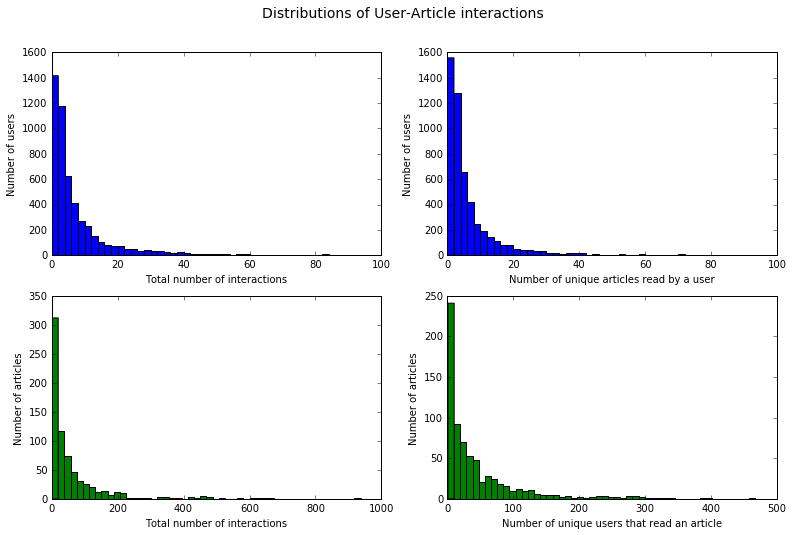

In [8]:
# For each user, count the number of all interactions and the number of unique articles they read
count_total_by_user = df_inter.groupby('user_id')['inter_count'].sum()
count_unique_by_user = df_inter.groupby('user_id').size()

# Do the same for articles
count_total_by_article = df_inter.groupby('article_id')['inter_count'].sum()
count_unique_by_article = df_inter.groupby('article_id').size()

fig, ax = plt.subplots(2,2, figsize=(13,8))
ax[0,0].hist(count_total_by_user, bins=50, range=(0,100))
ax[0,0].set_xlabel('Total number of interactions')
ax[0,0].set_ylabel('Number of users')
ax[0,1].hist(count_unique_by_user, bins=50, range=(0,100))
ax[0,1].set_xlabel('Number of unique articles read by a user')
ax[0,1].set_ylabel('Number of users')

ax[1,0].hist(count_total_by_article, bins=50, color='green')
ax[1,0].set_xlabel('Total number of interactions')
ax[1,0].set_ylabel('Number of articles')
ax[1,1].hist(count_unique_by_article, bins=50, color='green')
ax[1,1].set_xlabel('Number of unique users that read an article')
ax[1,1].set_ylabel('Number of articles')

fig.suptitle('Distributions of User-Article interactions', fontsize=14)


In [9]:
# Fill in the median and maximum number of user_article interactions below
median_val = count_unique_by_user.median()
max_views_by_user = count_total_by_user.max()

print('50% of individuals interact with {:.0f} number of articles or fewer.'.format(median_val))
print('The maximum number of user-article interactions by any 1 user is {:d}.'.format(max_views_by_user))

50% of individuals interact with 3 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`3.` Next, we update the aggregate parameters for the cleaned and merged dataset:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

Note: In the following cell, the number of articles merged from the Interactions table is subtracted from the total number of articles in order to match the intended results and pass the checks. However, we believe they should be included in the count, since they are present on the platform and have been read as is evident from the Interactions table.

In [10]:
unique_articles = df_inter.article_id.nunique() # The number of unique articles that have at least one interaction
total_articles = df_cont.shape[0] - num_added_articles # The number of unique articles on the IBM platform
unique_users = df_inter.user_id.nunique()-1 # The number of unique users (excluding the one with NaN email)
user_article_interactions = df_inter.inter_count.sum() # The number of user-article interactions

print('The number of unique (original) articles that have at least one interaction: {:d}'.format(unique_articles))
print('The number of unique (original) articles on the IBM platform: {:d}'.format(total_articles))
print('The number of unique users: {:d}'.format(unique_users))
print('The number of user-article interactions: {:d}'.format(user_article_interactions))


The number of unique (original) articles that have at least one interaction: 714
The number of unique (original) articles on the IBM platform: 1051
The number of unique users: 5148
The number of user-article interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [11]:
most_viewed_article_id = '{:.1f}'.format(count_total_by_article.idxmax()) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = count_total_by_article.max() # The most viewed article in the dataset was viewed how many times?

In [12]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [13]:
def get_top_articles(n, df=df_inter, df_cont=df_cont):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook
    df_cont - (pandas dataframe) dataframe that stores the content (e.g. articles names)
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    
    top_articles_ids = get_top_article_ids(n, df)
    
    top_articles = df_cont[df_cont['article_id'].isin(top_articles_ids)].doc_full_name.str.lower()
    
    return top_articles.tolist() # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df_inter):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    # Your code here
    
    top_articles_ids = df.groupby('article_id')['inter_count'].sum().sort_values(ascending=False).index
 
    return top_articles_ids[:n].tolist() # Return the top article ids

In [14]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['analyze energy consumption in buildings', 'apache spark lab, part 1: basic concepts', 'finding optimal locations of new store using decision optimization', 'gosales transactions for logistic regression model', 'healthcare python streaming application demo', 'insights from new york car accident reports', 'predicting churn with the spss random tree algorithm', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'use deep learning for image classification', 'visualize car data with brunel']
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [15]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [16]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df=df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Combine repeated user-article interactions
    df = df.groupby(by=['article_id', 'user_id']).size().rename('inter_count').reset_index()
    
    user_item_count = df.pivot(index='user_id', columns='article_id', values='inter_count').fillna(0)
    user_item = user_item_count.where(user_item_count==0, 1)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix()


In [17]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [18]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity = user_item.dot(user_item.loc[user_id,:])

    # remove the own user's id and sort by similarity
    similarity = similarity.drop(index=user_id).sort_values(ascending=False)

    # create list of just the ids
    most_similar_users = similarity.index.tolist()

       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [19]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 3697]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [20]:
def get_article_names(article_ids, df=df_cont):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) the content datafarme as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Convert article ids from str to int
    article_ids = [int(float(i)) for i in article_ids]
    
    # Your code here
    article_names = df.loc[df['article_id'].isin(article_ids), 'doc_full_name'].str.lower().tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    
    article_seen_bool = (user_item.loc[user_id,:]==1)
    article_ids = article_seen_bool.index[article_seen_bool].tolist()
    article_ids = ['{:.1f}'.format(i) for i in article_ids]
    
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations (article id's) for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Find article id's seen by the user
    seen_article_ids = get_user_articles(user_id)[0]
    
    # Assemble the list of recommendations
    recommended_article_ids = []
    for i_u in find_similar_users(user_id):
        for i_a in get_user_articles(i_u)[0]:
            if i_a not in recommended_article_ids+seen_article_ids:
                recommended_article_ids.append(i_a)
                if len(recommended_article_ids) == m:
                    return recommended_article_ids

    return recommended_article_ids 

In [21]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

In [22]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [23]:
def get_top_sorted_users(user_id, df=df_inter, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df_inter as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # compute similarity of each user to the provided user
    similarity = user_item.dot(user_item.loc[user_id,:])
    # remove the own user's id and sort by similarity
    similarity = similarity.drop(index=user_id).sort_values(ascending=False)
    # create list of just the ids
    neighbor_id = similarity.index.tolist()

    count_total_by_user = df_inter.groupby('user_id')['inter_count'].sum()
    count_unique_by_user = df_inter.groupby('user_id').size()
    num_interactions = count_total_by_user[neighbor_id].tolist()

    neighbors_df = pd.DataFrame(
                                data={'neighbor_id': neighbor_id,
                                      'similarity': similarity.tolist(),
                                      'num_interactions': num_interactions}
                                )
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], inplace=True, ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Find article id's seen by the user
    seen_article_ids = get_user_articles(user_id)[0]
    
    # Assemble the list of recommendations
    recommended_article_ids = []
    for i_u in find_similar_users(user_id):
        for i_a in get_user_articles(i_u)[0]:
            if i_a not in recommended_article_ids+seen_article_ids:
                recommended_article_ids.append(i_a)
                if len(recommended_article_ids) == m:
                    
                    rec_names = get_article_names(recommended_article_ids)
                    return recommended_article_ids, rec_names
                
    rec_names = get_article_names(recommended_article_ids)

    return recommended_article_ids, rec_names

In [24]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['43.0', '109.0', '111.0', '112.0', '164.0', '213.0', '225.0', '313.0', '337.0', '379.0']

The top 10 recommendations for user 20 are the following article names:
['deep learning with tensorflow course by big data university', 'tensorflow quick tips', 'tidy up your jupyter notebooks with scripts', 'building custom machine learning algorithms with apache systemml', 'learn tensorflow and deep learning together and now!', 'modeling energy usage in new york city', 'a visual explanation of the back propagation algorithm for neural networks', 'what is machine learning?', 'generalization in deep learning', 'data structures related to machine learning algorithms']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [25]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(user_id=1).loc[0,'neighbor_id'] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(user_id=131).loc[9,'neighbor_id'] # Find the 10th most similar user to user 131

In [26]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

The simplest way to provide recommendations ofr a new user is to use the most popular articles in the dataset. This can be obtained with the 'get_top_article_ids' and 'get_top_articles' functions.

To improve on this, it might be sensible to check if there is any internal structure in the set of known users that can be exploited. For example, if there are a few distinct clusters of users (defined by their common prefferences), for a new user, we might recomment a few top articles from each cluster instead of the top articles from the whole dataset. Depending on the distribution of cluseter sizes, this choice may improve the diversity of recommendations.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [27]:
# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = ['{:.1f}'.format(i) for i in get_top_article_ids(10)]

In [28]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [29]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [30]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [31]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [32]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [33]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

The situation here differs from that in the lesson because the user_item_matrix being decomposed is effectively a binary matrix with 0/1 values corresponding to whether a certain user interacted with a specific article. Since there are no missing entries (they are effectively filled with zeros), the usual SVD algorithm can be used. In contrast, in the example in the lesson, the matrix contains integer ratings for seen movies along with missing values in cases where a person didn't watch a specific movie. The missing entries in the matrix preclude the use of SVD algorithm, but its modifications (FunkSVD) can be used instead.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

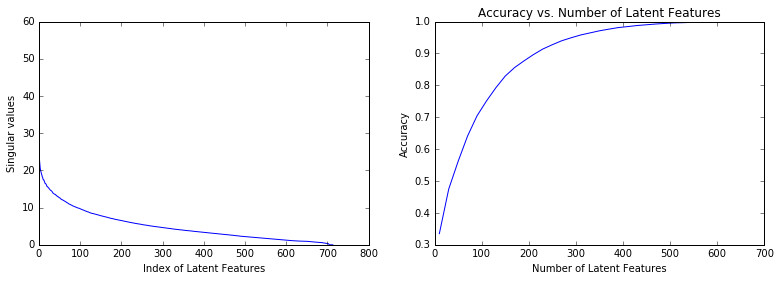

In [34]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
fig, ax = plt.subplots(1,2,figsize=(13,4))
ax[0].plot(s)
ax[0].set_xlabel('Index of Latent Features')
ax[0].set_ylabel('Singular values')
ax[1].plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
ax[1].set_xlabel('Number of Latent Features');
ax[1].set_ylabel('Accuracy');
ax[1].set_title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [35]:
df_train = df.head(40000)
df_test = df.tail(5993)



def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    train_idx - all of the train user ids
    test_arts - all of the test article ids
    train_arts - all of the train article ids
    
    '''
    user_item_train = create_user_item_matrix(df=df_train)
    user_item_test = create_user_item_matrix(df=df_test)
    
    test_idx = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()
    train_idx = user_item_train.index.tolist()
    train_arts = user_item_train.columns.tolist()
    
    return user_item_train, user_item_test, train_idx, test_idx, train_arts, test_arts

user_item_train, user_item_test, train_idx, test_idx, train_arts, test_arts = create_test_and_train_user_item(df_train, df_test)

In [36]:
print( 'How many users can we make predictions for in the test set?' )
print( len(set(df_train.user_id).intersection(df_test.user_id)) )

print('\nHow many users in the test set are we not able to make predictions for because of the cold start problem?')
print(len(set(df_test.user_id).difference(df_train.user_id)))

print('\nHow many articles can we make predictions for in the test set?')
print(len(set(df_train.article_id).intersection(df_test.article_id)))

print('\nHow many articles in the test set are we not able to make predictions for because of the cold start problem?')
print(len(set(df_test.article_id).difference(df_train.article_id)))

How many users can we make predictions for in the test set?
20

How many users in the test set are we not able to make predictions for because of the cold start problem?
662

How many articles can we make predictions for in the test set?
574

How many articles in the test set are we not able to make predictions for because of the cold start problem?
0


In [37]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many articles can we make predictions for in the test set?': b, # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [38]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)   # fit svd similar to above then use the cells below

In [39]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
user_ids_can_predict = set(df_train.user_id).intersection(df_test.user_id)
article_ids_can_predict = sorted(list( set(df_train.article_id).intersection(df_test.article_id) ))
rows_can_predict = df[df.user_id.isin(user_ids_can_predict)].sort_values('user_id')
print('User IDs can predict:')
print(sorted(list(user_ids_can_predict)))
print('\nCan predict {:d} users / {:d} rows of the test df.'.format(len(user_ids_can_predict), len(rows_can_predict)))

# Form the matrices U,V for users and articles that we can predict
u_train_sel = u_train[[train_idx.index(i) for i in user_ids_can_predict], :]
vt_train_sel = vt_train[:, [train_arts.index(i) for i in article_ids_can_predict]]

# Test user-items matrix restricted to only the users that we can predict
user_item_test_sel = user_item_test.loc[user_ids_can_predict, article_ids_can_predict]

User IDs can predict:
[2917, 3024, 3093, 3193, 3527, 3532, 3684, 3740, 3777, 3801, 3968, 3989, 3990, 3998, 4002, 4204, 4231, 4274, 4293, 4487]

Can predict 20 users / 674 rows of the test df.


The optimal number of latent features to retain is (approx.) 10


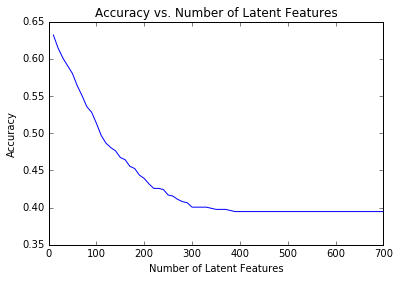

In [40]:
# Find the optimal number of latent features

num_latent_feats = np.arange(10,700+10,10)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train_sel[:, :k], vt_train_sel[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test_sel, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
accuracy = 1 - np.array(sum_errs)/len(rows_can_predict)

plt.plot(num_latent_feats, accuracy);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features')

print('The optimal number of latent features to retain is (approx.) {:d}'.format(num_latent_feats[accuracy.argmax()]) )

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

When the trainig and testing of the prediction algorithm are performed on separate parts of the dataset, we observe that the accuracy does not increase monotonically as more latent features in the SVD decomposition are retained. Instead, there is a clear optimal number of features (110) that produces the highest possible accuracy of prediction (0.71) on the considered train/test split. If the number of feautures is increased beyond 100, the accuracy drops notably due to the effects of oberfitting on the training set.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [41]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0